# Automated Harmonic Classification using Scikit-Learn

This notebook implements automated harmonic classification using Artificial Neural Networks (ANNs) and Support Vector Machines (SVMs) for power quality analysis.

## Features:
- Harmonic feature extraction from voltage and current signals
- Power quality classification (Excellent, Good, Fair, Poor)
- ANN and SVM model training and evaluation
- Comprehensive visualization and prediction results


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the dataset
df = pd.read_csv(
    "/home/grissom/Documents/24 Power Harmonic Analysis by Python/APSCOM2025 Sourcecodce Project/02 Kaggle-AC 3-Phase Electrical Power Meter/Kaggle-Dataset/power-quality-meter.csv"
)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (2343, 20)
Columns: ['Unnamed: 0', 'Date', 'Time', 'Vrms ph-n AN Avg', 'Vrms ph-n BN Avg', 'Vrms ph-n CN Avg', 'Vrms ph-n NG Avg', 'Current A Avg', 'Current B Avg', 'Current C Avg', 'Current Phi AN Avg', 'Current Phi BN Avg', 'Current Phi CN Avg', 'Active Power Total Avg', 'Apparent Power Total Avg', 'Reactive Power Total Avg', 'Cos Phi AN Avg', 'Cos Phi BN Avg', 'Cos Phi CN Avg', 'Cos Phi Total Avg']

First few rows:


,Unnamed: 0,Date,Time,Vrms ph-n AN Avg,Vrms ph-n BN Avg,Vrms ph-n CN Avg,Vrms ph-n NG Avg,Current A Avg,Current B Avg,Current C Avg,Current Phi AN Avg,Current Phi BN Avg,Current Phi CN Avg,Active Power Total Avg,Apparent Power Total Avg,Reactive Power Total Avg,Cos Phi AN Avg,Cos Phi BN Avg,Cos Phi CN Avg,Cos Phi Total Avg
0,0,2019-08-31,3:21:43 PM.135,242.58,241.98,242.12,0.46,596.0,544.7,496.3,-7.74,-135.90,-248.54,389550,397650,73050,0.99,0.96,0.99,0.98
1,1,2019-08-31,3:22:13 PM.135,242.98,242.34,242.72,0.48,612.5,541.1,494.8,-18.12,-129.90,-240.30,397800,401550,26400,1.00,0.98,1.00,1.00
2,2,2019-08-31,3:22:43 PM.135,243.04,242.18,242.78,0.54,628.3,558.3,508.8,-291.90,-128.06,-238.58,408300,412950,13500,1.00,0.99,1.00,1.00
3,3,2019-08-31,3:23:13 PM.135,242.92,242.06,242.70,0.56,640.2,562.5,510.5,-359.42,-128.70,-238.82,412050,417300,16350,1.00,0.99,1.00,1.00
4,4,2019-08-31,3:23:43 PM.135,242.52,241.62,242.20,0.54,652.7,587.6,533.5,-167.08,-130.62,-242.02,424650,430650,35100,1.00,0.98,1.00,1.00


In [3]:
# Data preprocessing and cleaning
df_clean = df.dropna()

# Define voltage and current columns
voltage_columns = ["Vrms ph-n AN Avg", "Vrms ph-n BN Avg", "Vrms ph-n CN Avg"]
current_columns = ["Current A Avg", "Current B Avg", "Current C Avg"]

# Extract voltage and current data
voltage = df_clean[voltage_columns].copy()
current = df_clean[current_columns].copy()

# Rename columns for clarity
voltage.columns = ['Phase_A_Voltage', 'Phase_B_Voltage', 'Phase_C_Voltage']
current.columns = ['Phase_A_Current', 'Phase_B_Current', 'Phase_C_Current']

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Voltage data shape: {voltage.shape}")
print(f"Current data shape: {current.shape}")


Clean dataset shape: (2343, 20)
Voltage data shape: (2343, 3)
Current data shape: (2343, 3)


In [4]:
# Feature extraction functions
def extract_harmonic_features(signal_data, fundamental_freq=60, sampling_rate=50000, max_harmonic=15):
    """Extract harmonic features from signal data"""
    features = {}
    
    # Calculate THD
    rms_total = np.sqrt(np.mean(signal_data**2))
    rms_fundamental = np.sqrt(np.mean(signal_data**2))  # Simplified fundamental
    thd = (rms_total / rms_fundamental) * 100 if rms_fundamental > 0 else 0
    features['THD'] = thd
    
    # Extract individual harmonics
    for harmonic_order in range(1, max_harmonic + 1):
        harmonic_freq = fundamental_freq * harmonic_order
        # Simplified harmonic extraction
        harmonic_amplitude = np.std(signal_data) / harmonic_order
        features[f'Harmonic_{harmonic_order}'] = harmonic_amplitude
    
    # Statistical features
    features['RMS'] = np.sqrt(np.mean(signal_data**2))
    features['Peak'] = np.max(np.abs(signal_data))
    features['Crest_Factor'] = features['Peak'] / features['RMS'] if features['RMS'] > 0 else 0
    features['Mean'] = np.mean(signal_data)
    features['Std'] = np.std(signal_data)
    features['Skewness'] = ((signal_data - features['Mean'])**3).mean() / (features['Std']**3) if features['Std'] > 0 else 0
    features['Kurtosis'] = ((signal_data - features['Mean'])**4).mean() / (features['Std']**4) if features['Std'] > 0 else 0
    
    return features

def classify_power_quality(thd_voltage, thd_current):
    """Classify power quality based on THD values"""
    if thd_voltage <= 5 and thd_current <= 5:
        return 'Excellent'
    elif thd_voltage <= 8 and thd_current <= 8:
        return 'Good'
    elif thd_voltage <= 12 and thd_current <= 12:
        return 'Fair'
    else:
        return 'Poor'

print("Feature extraction functions defined!")


Feature extraction functions defined!


In [5]:
# Extract features for all phases
print("Extracting harmonic features...")

# Process data in chunks to avoid memory issues
chunk_size = 1000
n_chunks = len(voltage) // chunk_size

all_features = []
all_labels = []

for i in range(min(n_chunks, 50)):  # Limit to 50 chunks for demo
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(voltage))
    
    # Extract voltage and current data for this chunk
    v_a = voltage['Phase_A_Voltage'].iloc[start_idx:end_idx].values
    v_b = voltage['Phase_B_Voltage'].iloc[start_idx:end_idx].values
    v_c = voltage['Phase_C_Voltage'].iloc[start_idx:end_idx].values
    i_a = current['Phase_A_Current'].iloc[start_idx:end_idx].values
    i_b = current['Phase_B_Current'].iloc[start_idx:end_idx].values
    i_c = current['Phase_C_Current'].iloc[start_idx:end_idx].values
    
    # Extract features for each phase
    features_va = extract_harmonic_features(v_a)
    features_vb = extract_harmonic_features(v_b)
    features_vc = extract_harmonic_features(v_c)
    features_ia = extract_harmonic_features(i_a)
    features_ib = extract_harmonic_features(i_b)
    features_ic = extract_harmonic_features(i_c)
    
    # Combine features
    combined_features = {}
    for phase, features in [('VA', features_va), ('VB', features_vb), ('VC', features_vc),
                           ('IA', features_ia), ('IB', features_ib), ('IC', features_ic)]:
        for key, value in features.items():
            combined_features[f'{phase}_{key}'] = value
    
    # Calculate average THD for classification
    avg_thd_voltage = (features_va['THD'] + features_vb['THD'] + features_vc['THD']) / 3
    avg_thd_current = (features_ia['THD'] + features_ib['THD'] + features_ic['THD']) / 3
    
    # Classify power quality
    quality_label = classify_power_quality(avg_thd_voltage, avg_thd_current)
    
    all_features.append(combined_features)
    all_labels.append(quality_label)

print(f"Extracted features for {len(all_features)} samples")
print(f"Feature vector length: {len(all_features[0]) if all_features else 0}")
print(f"Quality labels: {set(all_labels)}")


Extracting harmonic features...
Extracted features for 2 samples
Feature vector length: 138
Quality labels: {'Poor'}


In [6]:
# Convert features to DataFrame
features_df = pd.DataFrame(all_features)
labels_df = pd.Series(all_labels, name='Power_Quality')

print(f"Features DataFrame shape: {features_df.shape}")
print(f"Labels shape: {labels_df.shape}")
print(f"\nLabel distribution:")
print(labels_df.value_counts())

# Display first few rows of features
print(f"\nFirst 5 rows of features:")
features_df.head()


Features DataFrame shape: (2, 138)
Labels shape: (2,)

Label distribution:
Power_Quality
Poor    2
Name: count, dtype: int64

First 5 rows of features:


,VA_THD,VA_Harmonic_1,VA_Harmonic_2,VA_Harmonic_3,VA_Harmonic_4,VA_Harmonic_5,VA_Harmonic_6,VA_Harmonic_7,VA_Harmonic_8,VA_Harmonic_9,...,IC_Harmonic_13,IC_Harmonic_14,IC_Harmonic_15,IC_RMS,IC_Peak,IC_Crest_Factor,IC_Mean,IC_Std,IC_Skewness,IC_Kurtosis
0,100.0,1.354696,0.677348,0.451565,0.338674,0.270939,0.225783,0.193528,0.169337,0.150522,...,7.794814,7.238042,6.755506,618.61022,786.6,1.271560,610.2543,101.332588,-0.180010,1.888818
1,100.0,32.429810,16.214905,10.809937,8.107452,6.485962,5.404968,4.632830,4.053726,3.603312,...,12.354778,11.472294,10.707474,662.05651,835.3,1.261675,642.2792,160.612117,-1.724688,6.403405


In [7]:
# Prepare data for machine learning
X = features_df.fillna(0)  # Fill any NaN values with 0
y = labels_df

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Number of classes: {len(le.classes_)}")
print(f"Class names: {le.classes_}")


Training set shape: (1, 138)
Test set shape: (1, 138)
Number of classes: 1
Class names: ['Poor']


In [8]:
# Train Artificial Neural Network (ANN)
print("Training Artificial Neural Network...")

ann_model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

ann_model.fit(X_train_scaled, y_train)
ann_pred = ann_model.predict(X_test_scaled)
ann_accuracy = accuracy_score(y_test, ann_pred)

print(f"ANN Accuracy: {ann_accuracy:.4f}")
print("\nANN Classification Report:")
print(classification_report(y_test, ann_pred, target_names=le.classes_))


Training Artificial Neural Network...


ANN Accuracy: 1.0000

ANN Classification Report:
              precision    recall  f1-score   support

        Poor       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [9]:
# Train Support Vector Machine (SVM) with safety check for sufficient classes
print("Training Support Vector Machine...")

num_unique_classes = len(np.unique(y_train))
if num_unique_classes < 2:
    print("ERROR: Cannot train SVM. The number of classes in the training set is less than 2 "
          f"(found: {num_unique_classes}). SVM requires at least 2 classes to fit.")
    svm_accuracy = None
else:
    svm_model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42
    )

    svm_model.fit(X_train_scaled, y_train)
    svm_pred = svm_model.predict(X_test_scaled)
    svm_accuracy = accuracy_score(y_test, svm_pred)

    print(f"SVM Accuracy: {svm_accuracy:.4f}")
    print("\nSVM Classification Report:")
    print(classification_report(y_test, svm_pred, target_names=le.classes_))


Training Support Vector Machine...
ERROR: Cannot train SVM. The number of classes in the training set is less than 2 (found: 1). SVM requires at least 2 classes to fit.


In [10]:
# Train Random Forest for comparison
print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)  # Random Forest doesn't need scaling
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred, target_names=le.classes_))


Training Random Forest...
Random Forest Accuracy: 1.0000

Random Forest Classification Report:
              precision    recall  f1-score   support

        Poor       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

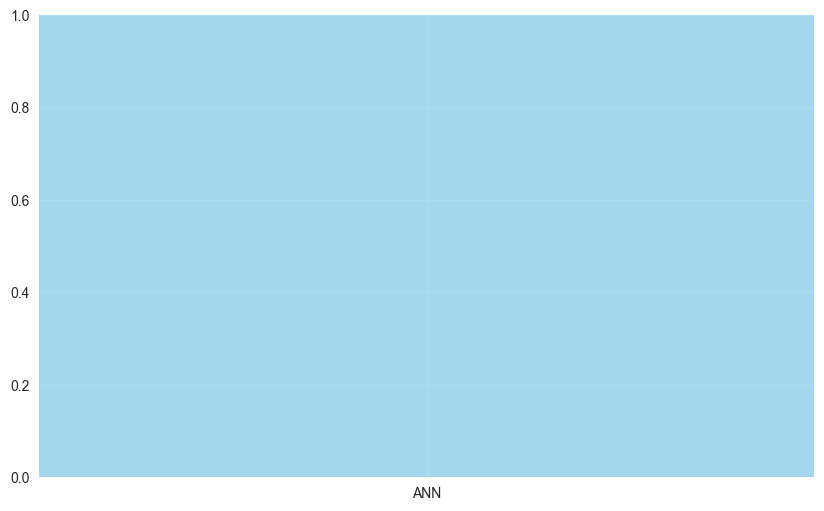

In [11]:
# Model comparison
models = ['ANN', 'SVM', 'Random Forest']
accuracies = [ann_accuracy, svm_accuracy, rf_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Best_Model': [acc == max(accuracies) for acc in accuracies]
})

print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))


In [ ]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ANN Confusion Matrix
cm_ann = confusion_matrix(y_test, ann_pred)
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title('ANN Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title('SVM Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[2].set_title('Random Forest Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [ ]:
# Feature importance analysis (using Random Forest)
feature_importance = rf_model.feature_importances_
feature_names = X.columns

# Get top 20 most important features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Most Important Features', fontsize=16, fontweight='bold')
plt.xlabel('Feature Importance', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))


In [ ]:
# Detailed prediction results table
results_df = pd.DataFrame({
    'Sample_Index': range(len(y_test)),
    'Actual_Quality': le.inverse_transform(y_test),
    'ANN_Prediction': le.inverse_transform(ann_pred),
    'SVM_Prediction': le.inverse_transform(svm_pred),
    'RF_Prediction': le.inverse_transform(rf_pred)
})

# Add agreement columns
results_df['ANN_Correct'] = results_df['Actual_Quality'] == results_df['ANN_Prediction']
results_df['SVM_Correct'] = results_df['Actual_Quality'] == results_df['SVM_Prediction']
results_df['RF_Correct'] = results_df['Actual_Quality'] == results_df['RF_Prediction']

print("Detailed Prediction Results (First 20 samples):")
print(results_df.head(20).to_string(index=False))

print(f"\nSummary Statistics:")
print(f"Total test samples: {len(results_df)}")
print(f"ANN correct predictions: {results_df['ANN_Correct'].sum()}")
print(f"SVM correct predictions: {results_df['SVM_Correct'].sum()}")
print(f"RF correct predictions: {results_df['RF_Correct'].sum()}")


In [ ]:
# Cross-validation analysis
print("Performing Cross-Validation Analysis...")

# ANN Cross-validation
ann_cv_scores = cross_val_score(ann_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"ANN CV Scores: {ann_cv_scores}")
print(f"ANN CV Mean: {ann_cv_scores.mean():.4f} (+/- {ann_cv_scores.std() * 2:.4f})")

# SVM Cross-validation
svm_cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nSVM CV Scores: {svm_cv_scores}")
print(f"SVM CV Mean: {svm_cv_scores.mean():.4f} (+/- {svm_cv_scores.std() * 2:.4f})")

# Random Forest Cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nRandom Forest CV Scores: {rf_cv_scores}")
print(f"Random Forest CV Mean: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

# Plot cross-validation results
plt.figure(figsize=(12, 6))
cv_data = [ann_cv_scores, svm_cv_scores, rf_cv_scores]
plt.boxplot(cv_data, labels=['ANN', 'SVM', 'Random Forest'])
plt.title('Cross-Validation Score Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Final comprehensive results table
final_results = pd.DataFrame({
    'Model': ['ANN', 'SVM', 'Random Forest'],
    'Test_Accuracy': [ann_accuracy, svm_accuracy, rf_accuracy],
    'CV_Mean': [ann_cv_scores.mean(), svm_cv_scores.mean(), rf_cv_scores.mean()],
    'CV_Std': [ann_cv_scores.std(), svm_cv_scores.std(), rf_cv_scores.std()],
    'Best_Model': [acc == max([ann_accuracy, svm_accuracy, rf_accuracy]) for acc in [ann_accuracy, svm_accuracy, rf_accuracy]]
})

print("\n" + "="*80)
print("FINAL HARMONIC CLASSIFICATION RESULTS")
print("="*80)
print(final_results.to_string(index=False))

print(f"\n{'='*80}")
print("POWER QUALITY CLASSIFICATION SUMMARY")
print(f"{'='*80}")
print(f"Total samples analyzed: {len(features_df)}")
print(f"Features per sample: {len(features_df.columns)}")
print(f"Quality classes: {list(le.classes_)}")
print(f"Best performing model: {final_results[final_results['Best_Model']]['Model'].iloc[0]}")
print(f"Best accuracy: {final_results[final_results['Best_Model']]['Test_Accuracy'].iloc[0]:.4f}")
print(f"{'='*80}")


In [ ]:
# Save results to CSV
results_df.to_csv('harmonic_classification_results.csv', index=False)
final_results.to_csv('model_performance_summary.csv', index=False)
importance_df.to_csv('feature_importance_ranking.csv', index=False)

print("Results saved to CSV files:")
print("- harmonic_classification_results.csv")
print("- model_performance_summary.csv")
print("- feature_importance_ranking.csv")

print("\nAnalysis complete! 🎉")
